In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA, NMF
from matplotlib import animation
from scipy.ndimage import gaussian_filter, convolve1d
from scipy.signal import convolve2d
import os

from devenw.nmf import poiss_train, censored_lstsq, censored_nnlstsq, cv_pca, downsample_tiff_avg, plot_nmf_t, plot_nmf_px

# for cvNMF
from numpy.random import randn, rand
from scipy.optimize import minimize
from devenw.nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Simulating data

In [2]:
# setting simulation params
xy_px = 64 
t_max = 2056
patch_size_max = 10
patch_size_min = 5
poiss_tau = 200
act_tau = 32
im_noise = 1.5
smoothing_sigma = 2
n_patches = 10
act_scaling = 3

# setting nmf params
n_components = n_patches + 5 # plot 5 additional component

# setting cv nmf params
replicates = 1 # can be run multiple times for robustness
r_max = n_components
step = 1 # increase step for long simulations


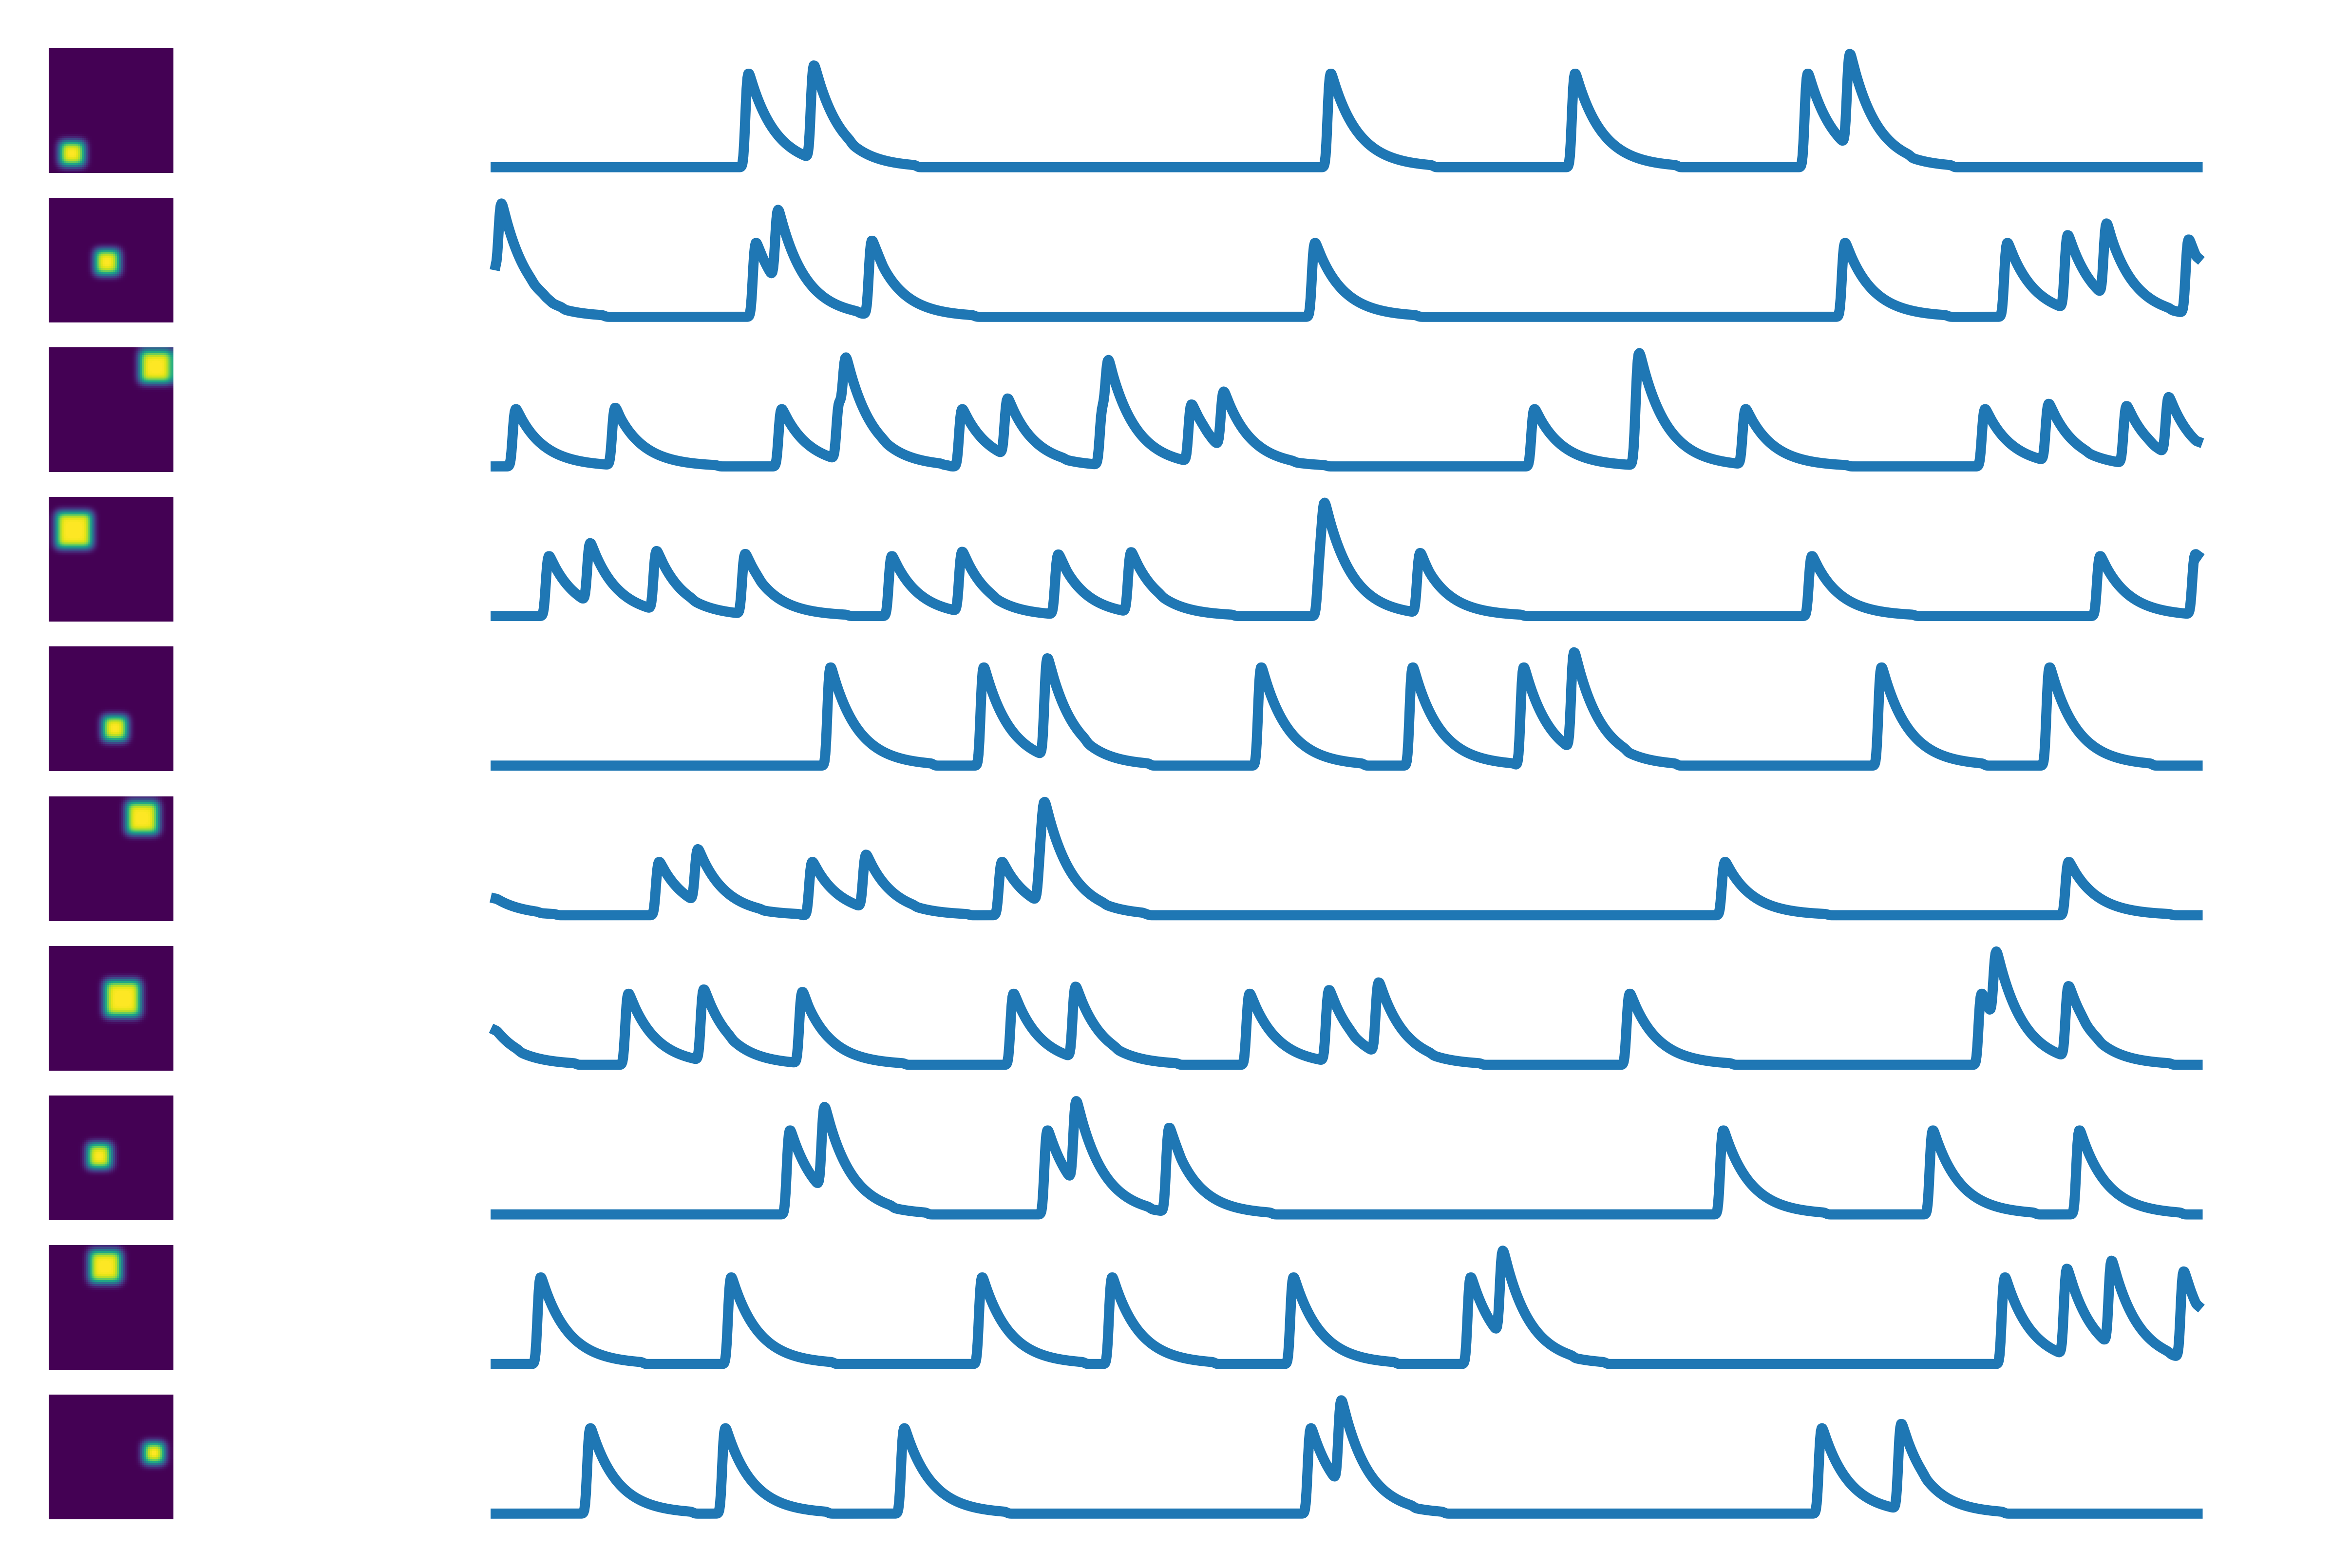

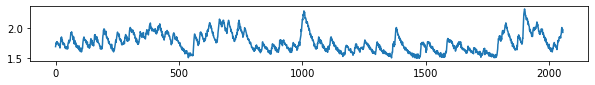

In [3]:
# running simulation

t = np.arange(0,t_max)
movie_blank = np.zeros((xy_px, xy_px, t_max))
movie = np.zeros((xy_px, xy_px, t_max))
gt_acts = []

act_kernel = np.exp(-np.arange(0,128)/act_tau)

_, axs = plt.subplots(n_patches, 2, dpi=1000, gridspec_kw={'width_ratios': [1, 10]})

for i in range(n_patches):
    sig1_d = random.randrange(patch_size_min,patch_size_max)
    sig1_x = random.randrange(sig1_d, xy_px-sig1_d)
    sig1_y = random.randrange(sig1_d, xy_px-sig1_d)

    sig_1 = np.copy(movie_blank)
    act_t,_ = poiss_train(poiss_tau, t_max=t_max)
    sig_1[sig1_x-sig1_d:sig1_x+sig1_d, sig1_y-sig1_d:sig1_y+sig1_d, np.round(act_t).astype(int)] = act_scaling
    
    
    sig_1 = convolve1d(sig_1, act_kernel) # smoothing in time
    sig_1 = gaussian_filter(sig_1,smoothing_sigma) # smoothing square in image
    
    axs[i,0].imshow(sig_1[:,:,np.round(act_t).astype(int)[0]]) 
    axs[i,0].axis('off')
    
    gt_act = np.mean(sig_1,(0,1))
    
    axs[i,1].plot(gt_act)
    axs[i,1].axis('off')
    
    gt_acts.append(gt_act)
    
    movie += sig_1

plt.show()

# adding noise
noise_mask = np.random.poisson(im_noise, movie.shape)
movie += noise_mask

# plotting mean movie
plt.figure(figsize=(10,1))
plt.plot(np.mean(movie,(0,1)))
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


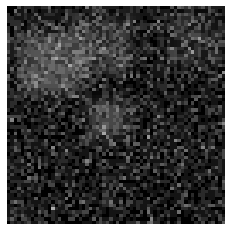

In [4]:
# make animation
fig = plt.figure()
im = plt.imshow(-movie[:,:,0], vmin=-np.max(movie), vmax=0, cmap='Greys')
plt.axis('off')

def ani_fun(i):
    im.set_array(-movie[:,:,i])
    return([im])
    
anim = animation.FuncAnimation(fig, ani_fun,
                               frames=movie.shape[2], interval=20, blit=True)
 
anim.save('test_anim.gif', fps=30)

# Running NMF on simulations

In [5]:
# run nmf on pixels
data = np.reshape(movie+1, (xy_px**2, t_max)).T
nmf_px = NMF(n_components=n_components)
#nmf_px.fit(data)
nmf_px.fit(data)

C:\Users\Jure\miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Jure\miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=15)

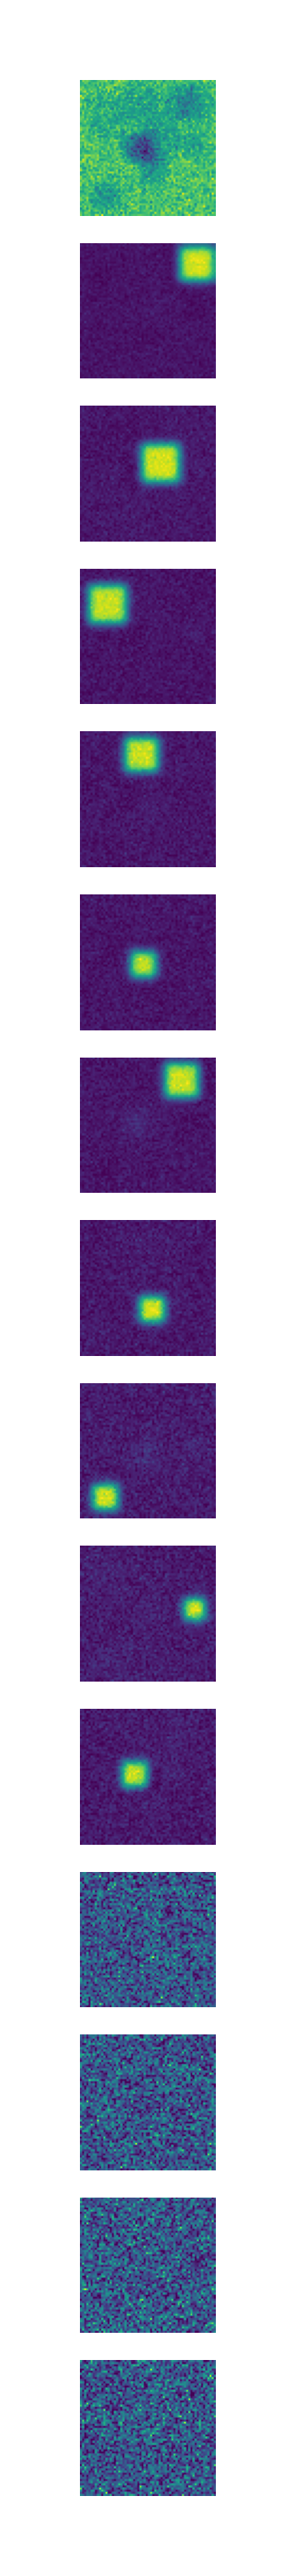

In [6]:
plot_nmf_px(nmf_px, xy_px)

In [7]:
# run nmf on pixels
nmf_t = NMF(n_components=n_components)
nmf_t.fit(data.T)

C:\Users\Jure\miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Jure\miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=15)

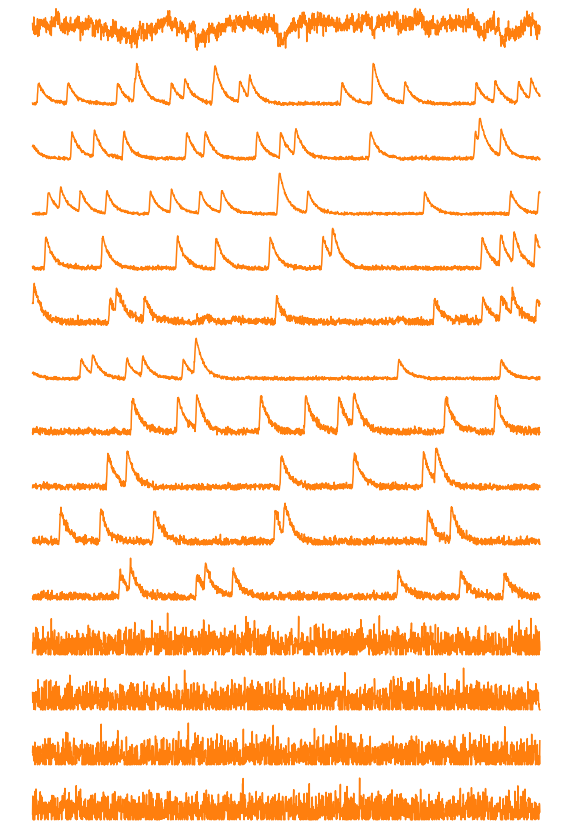

In [11]:
plot_nmf_t(nmf_t)

IndexError: list index out of range

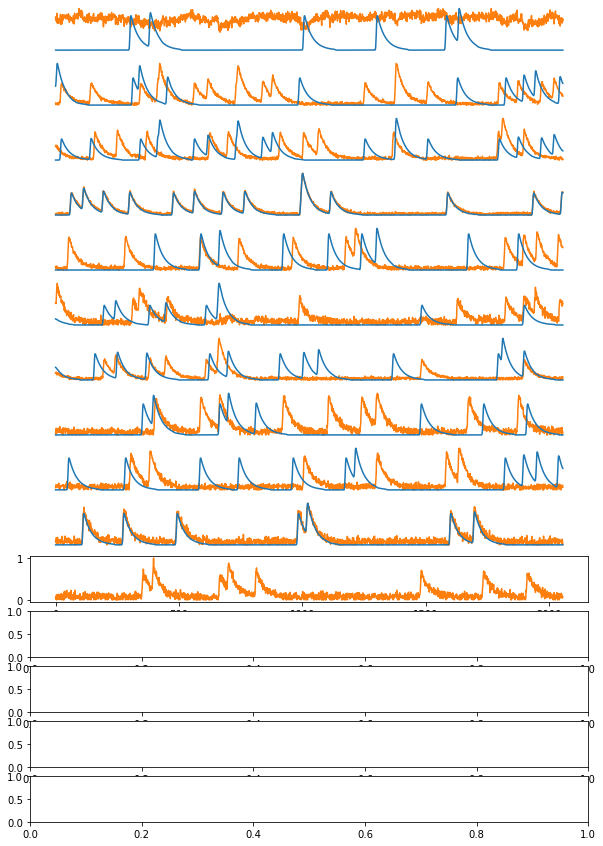

In [12]:
plot_nmf_t(nmf_t, gt_acts=gt_acts, plot_gt=True) # this function is broken for plotting against gt

In [13]:
ranks = np.arange(0, r_max, step)

train_err, test_err = [], []

# fit models
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    print(f'finished running for rank: {rnk} out of {r_max} (step = {step})')
    

finished running for rank: 0 out of 15 (step = 1)
finished running for rank: 1 out of 15 (step = 1)
finished running for rank: 2 out of 15 (step = 1)
finished running for rank: 3 out of 15 (step = 1)
finished running for rank: 4 out of 15 (step = 1)
finished running for rank: 5 out of 15 (step = 1)
finished running for rank: 6 out of 15 (step = 1)
finished running for rank: 7 out of 15 (step = 1)
finished running for rank: 8 out of 15 (step = 1)
finished running for rank: 9 out of 15 (step = 1)
finished running for rank: 10 out of 15 (step = 1)
finished running for rank: 11 out of 15 (step = 1)
finished running for rank: 12 out of 15 (step = 1)
finished running for rank: 13 out of 15 (step = 1)
finished running for rank: 14 out of 15 (step = 1)


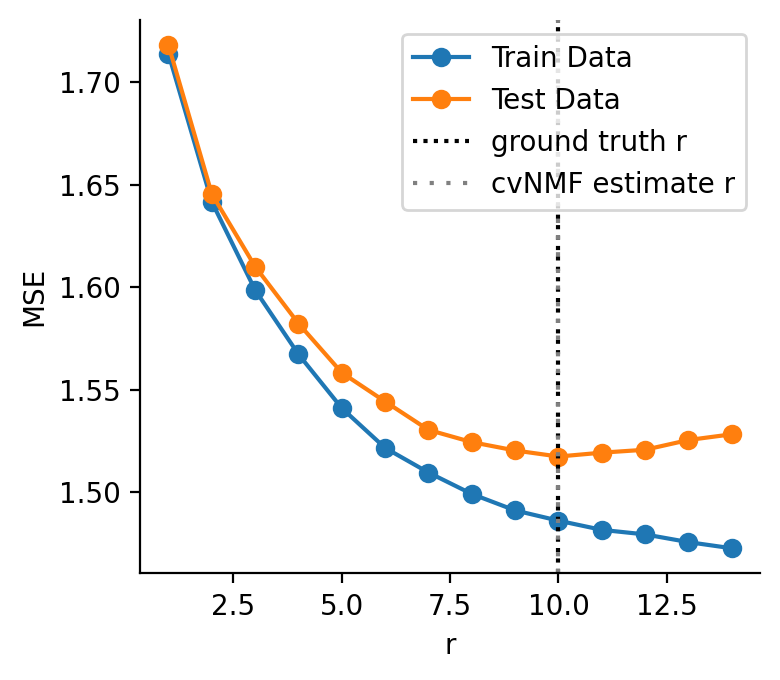

In [15]:
train_err_np = np.array([train_err[i][1] for i in range(len(train_err))])
test_err_np = np.array([test_err[i][1] for i in range(len(test_err))])

n_nmf_opt = np.argmin(test_err_np)

# make plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=200)
ax.plot(np.arange(1,len(train_err_np[1:])+1), train_err_np[1:], 'o-', label='Train Data') # without 'average' component
ax.plot(np.arange(1,len(test_err_np[1:])+1), test_err_np[1:], 'o-', label='Test Data') # without 'average' component
ax.set_ylabel('MSE')
ax.set_xlabel('r')
ax.axvline(n_patches, color='k', dashes=[1,1.5], label='ground truth r') # +1 because of mean component
ax.axvline(n_nmf_opt, color='grey', dashes=[1,3], label='cvNMF estimate r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
fig.tight_layout()

plt.savefig('cvNMF.png')

In [ ]:
# refit nmf with the optimal number of components? (probably not really necessary)